In [172]:
import numpy as np
import matplotlib.pyplot as plt


Given the unnormalized density: $p(x) = \exp(\frac{-x^2}{2})(\sin(x)^2+3\cos(x)^2\sin(7x)^2+1)$ for $x\in[-3,3]$, the task is to sample from this distribution and calculate $\mathbb{E}[x^2]$.

In [173]:
### define the probability density function p(x) = \exp(\frac{-x^2}{2})(\sin(x)^2+3\cos(x)^2\sin(7x)^2+1)
prob_func = lambda x: np.exp(-x**2/2)*(np.sin(x)**2+3*np.cos(x)**2*np.sin(7*x)**2+1)

x_range = (-3,3)

In [174]:
import numpy as np

### Do rejection sampling with a uniform proposal distribution
def rejection_sampling_uniform(N, prob_func, x_range, f_max):
    x = np.random.uniform(x_range[0], x_range[1], N)
    y = np.random.uniform(0, f_max, N)
    accepted = x[y<prob_func(x)]
    exp_val_x2 = np.mean(accepted**2)
    return accepted, exp_val_x2

def rejection_sampling_gaussian(N, prob_func, x_range,f_max=None):
    """
    Perform rejection sampling with a Gaussian proposal distribution.

    Args:
        N (int): Number of samples to generate.
        prob_func (callable): Target probability function f(x).
        x_range (tuple): The range (min, max) over which to sample.

    Returns:
        accepted_samples (np.ndarray): Array of accepted samples.
        k (float): The scaling factor used for the proposal distribution.
    """
    # Proposal distribution parameters
    mu = (x_range[0] + x_range[1]) / 2  #Center gaussian at midpoint of x_range
    sigma = (x_range[1] - x_range[0]) / 2  #Take sigma as half the range

    # Proposal PDF (Gaussian)
    proposal_pdf = lambda x: (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-((x - mu) ** 2) / (2 * sigma**2))

    # Find scaling factor k to ensure k * proposal_pdf(x) >= prob_func(x) for all x
    x_test = np.linspace(x_range[0], x_range[1], 1000)  # Fine grid over the range
    k = np.max(prob_func(x_test) / proposal_pdf(x_test))

    # Generate samples from the proposal distribution
    x_samples = np.random.normal(mu, sigma, N)

    # Generate uniform samples for y, scaled by k * proposal_pdf(x)
    y_samples = np.random.uniform(0, k * proposal_pdf(x_samples), N)

    # Accept samples where y < prob_func(x)
    accepted_samples = x_samples[y_samples < prob_func(x_samples)]

    return accepted_samples, k, exp_val_x2, proposal_pdf

    


In [181]:
def pick_y_max(f, x_range):
    x = np.linspace(*x_range, 1000)
    return np.max(f(x))

f_max = pick_y_max(prob_func, x_range)

N = 100
samples, exp_val_x2 = rejection_sampling_uniform(N, prob_func, x_range, f_max)
samples_gaussian, k, exp_val_x2_g, proposal_pdf = rejection_sampling_gaussian(N, prob_func, x_range, f_max)


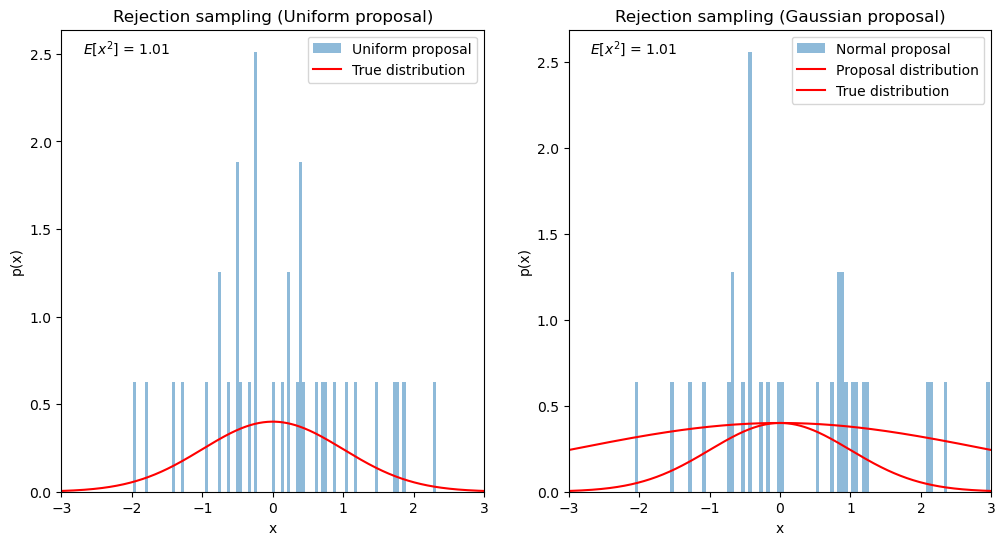

In [182]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
x = np.linspace(*x_range, 1000)
y = prob_func(x)
normalization = np.sum(y) * (x[1] - x[0])

# Plot for uniform proposal
ax[0].hist(samples, bins=100, density=True, alpha=0.5, label='Uniform proposal')
ax[0].set_xlabel('x')
ax[0].set_ylabel('p(x)')
ax[0].set_title('Rejection sampling (Uniform proposal)')
ax[0].text(0.05, 0.95, f'$E[x^2]$ = {exp_val_x2:.2f}', transform=ax[0].transAxes)

# Plot for normal proposal
ax[1].hist(samples_gaussian, bins=100, density=True, alpha=0.5, label='Normal proposal')
ax[1].set_xlabel('x')
ax[1].set_ylabel('p(x)')
ax[1].set_title('Rejection sampling (Gaussian proposal)')
ax[1].text(0.05, 0.95, f'$E[x^2]$ = {exp_val_x2_g:.2f}', transform=ax[1].transAxes)
ax[1].plot(np.linspace(*x_range, 1000), k/normalization*proposal_pdf(np.linspace(*x_range, 1000)), label='Proposal distribution', color='red')

# Plot true distribution on both axes
for i in range(2):
    ax[i].plot(x, y / normalization, label='True distribution', color='red')
    ax[i].legend()
    ax[i].set_xlim(x_range)

plt.show()

In [177]:
### self-normalized importance sampling with a normal proposal distribution

def importance_sampling_normal(N, prob_func, f_x, x_range):
    # Generate random samples from the proposal distribution (standard normal)
    x = np.random.normal(0, 1, N)
    
    # Define the proposal PDF (standard normal distribution)
    sigma, mu = 1, 0
    norm_dist = lambda x: 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)
    
    # Evaluate the target distribution, function, and proposal PDF
    p_x = prob_func(x)    # Target PDF
    f_x = f_x(x)          # Function values
    q_x = norm_dist(x)    # Proposal PDF
    
    # Compute normalized weights
    weights = p_x / q_x
    normalized_weights = weights / np.sum(weights)
    
    # Compute the expectation value
    exp_val = np.sum(f_x * normalized_weights)
    return exp_val

N = 100
prob_func = lambda x: np.exp(-x**2 / 2) / np.sqrt(2 * np.pi)  # Standard normal PDF
f_x = lambda x: x**2  # Function to compute expectation for

exp_val = importance_sampling_normal(N, prob_func, f_x, x_range)
print(f'Expectation value of x^2 (importance sampling): {exp_val:.2f}')




Expectation value of x^2 (importance sampling): 1.11


In [178]:


store_dict = {}
for N in [10, 100, 1000]:
    exp_val_u = []
    exp_val_g = []
    exp_val_is = []
    for rep in range(10):
        samples_u, exp_val_x2_u = rejection_sampling_uniform(N, prob_func, x_range, f_max)
        samples_g, k, exp_val_x2_g, proposal_pdf = rejection_sampling_gaussian(N, prob_func, x_range, f_max)
        f_x = lambda x: x**2
        exp_val_is_ = importance_sampling_normal(N, prob_func, f_x, x_range)
        exp_val_u.append(exp_val_x2_u)
        exp_val_g.append(exp_val_x2_g)
        exp_val_is.append(exp_val_is_)
    store_dict[N] = {'Rejection (uniform)': exp_val_u, 'Rejection (Gaussian)': exp_val_g, 'Importance sampling': exp_val_is}



    




/Users/marcusdreisler/miniconda3/envs/PML/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/marcusdreisler/miniconda3/envs/PML/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


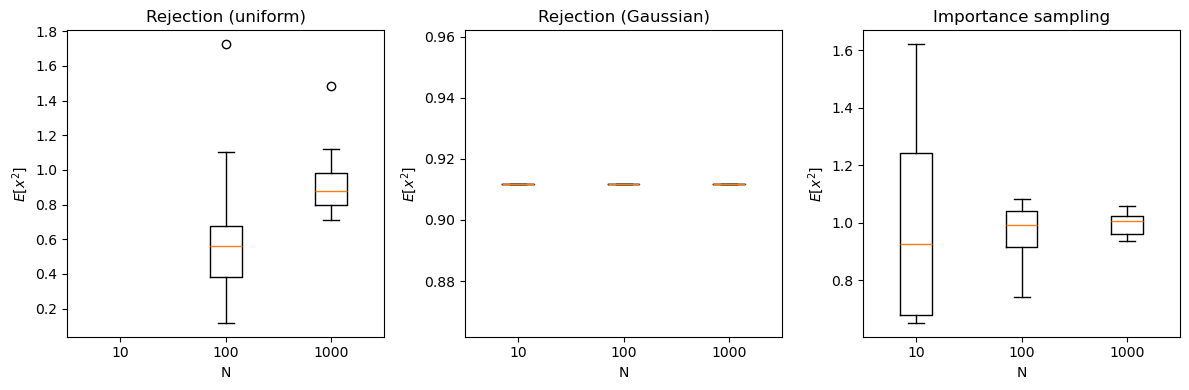

In [180]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
methods = ['Rejection (uniform)', 'Rejection (Gaussian)', 'Importance sampling']
for method, ax_ in zip(methods, ax):
    exp_vals = [store_dict[N][method] for N in [10, 100, 1000]]
    ax_.boxplot(exp_vals)
    ax_.set_title(method)
    ax_.set_xticklabels([10, 100, 1000])
    ax_.set_xlabel('N')
    ax_.set_ylabel('$E[x^2]$')


plt.tight_layout()
plt.show()


